In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 500
beta = torch.linspace(50e-4, 200e-4, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0018, device='cuda:0')

In [3]:
alpha_

tensor([0.9950, 0.9900, 0.9850, 0.9800, 0.9750, 0.9699, 0.9649, 0.9599, 0.9549,
        0.9498, 0.9448, 0.9397, 0.9347, 0.9297, 0.9246, 0.9196, 0.9146, 0.9095,
        0.9045, 0.8994, 0.8944, 0.8894, 0.8843, 0.8793, 0.8743, 0.8692, 0.8642,
        0.8592, 0.8542, 0.8491, 0.8441, 0.8391, 0.8341, 0.8291, 0.8241, 0.8191,
        0.8142, 0.8092, 0.8042, 0.7993, 0.7943, 0.7893, 0.7844, 0.7795, 0.7745,
        0.7696, 0.7647, 0.7598, 0.7549, 0.7500, 0.7451, 0.7403, 0.7354, 0.7306,
        0.7257, 0.7209, 0.7161, 0.7113, 0.7065, 0.7017, 0.6969, 0.6922, 0.6874,
        0.6827, 0.6779, 0.6732, 0.6685, 0.6638, 0.6592, 0.6545, 0.6498, 0.6452,
        0.6406, 0.6360, 0.6314, 0.6268, 0.6222, 0.6177, 0.6132, 0.6086, 0.6041,
        0.5996, 0.5952, 0.5907, 0.5862, 0.5818, 0.5774, 0.5730, 0.5686, 0.5643,
        0.5599, 0.5556, 0.5513, 0.5470, 0.5427, 0.5384, 0.5342, 0.5300, 0.5257,
        0.5216, 0.5174, 0.5132, 0.5091, 0.5050, 0.5009, 0.4968, 0.4927, 0.4887,
        0.4846, 0.4806, 0.4766, 0.4726, 

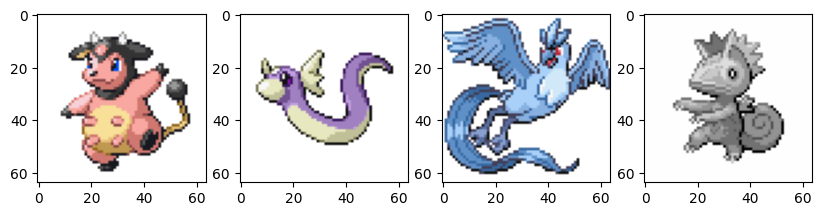

In [4]:
transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [6]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 64, 64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

  0%|          | 0/20001 [00:00<?, ?it/s]

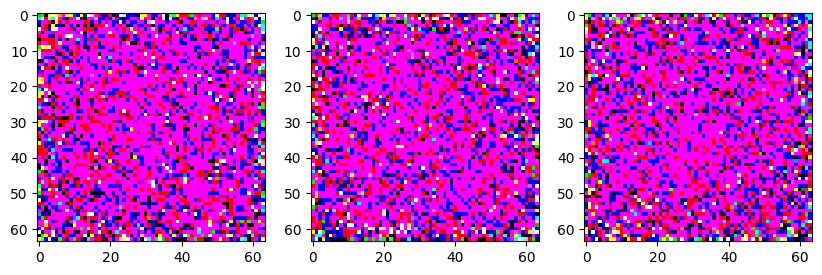

0.05115237:   2%|▏         | 499/20001 [00:49<28:06, 11.57it/s] 

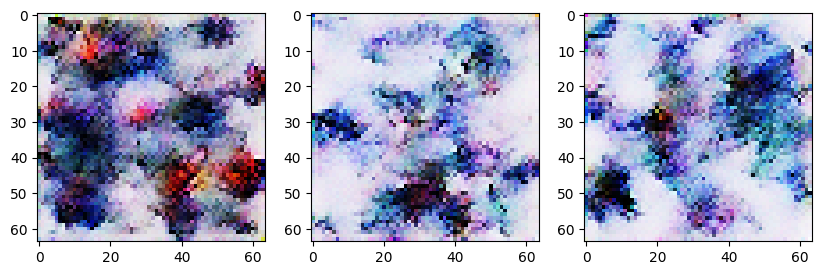

0.07687082:   5%|▍         | 999/20001 [01:39<27:26, 11.54it/s]  

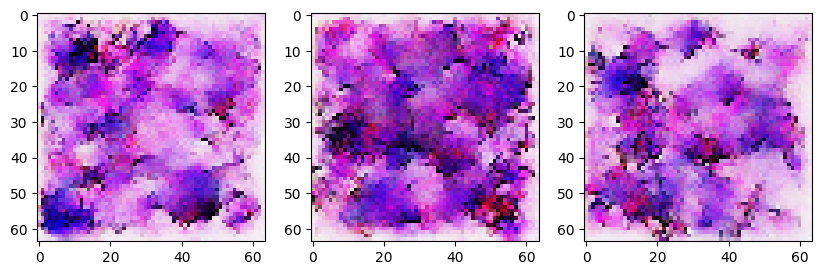

0.05724499:   7%|▋         | 1499/20001 [02:29<26:42, 11.55it/s]  

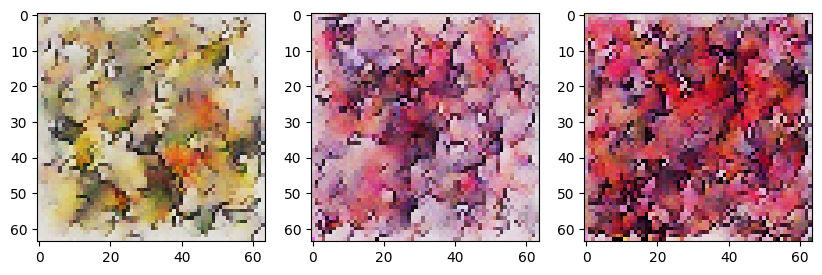

0.05270653:  10%|▉         | 1999/20001 [03:19<25:59, 11.55it/s]  

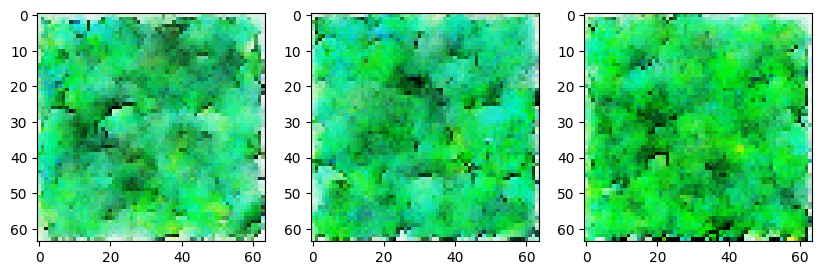

0.05882467:  12%|█▏        | 2499/20001 [04:08<25:13, 11.56it/s]  

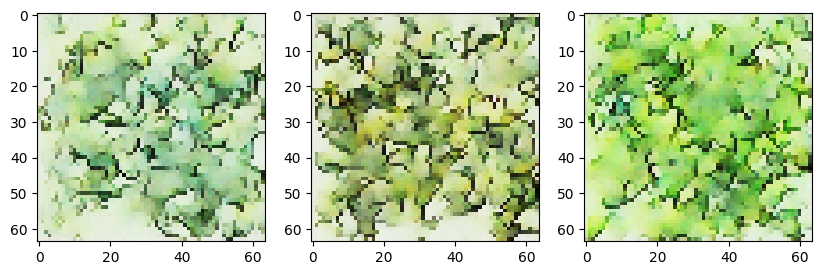

0.10388609:  15%|█▍        | 2999/20001 [04:58<24:29, 11.57it/s]  

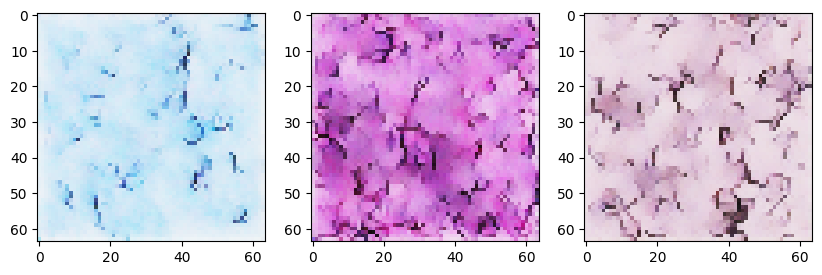

0.03592738:  17%|█▋        | 3499/20001 [05:47<23:45, 11.58it/s]  

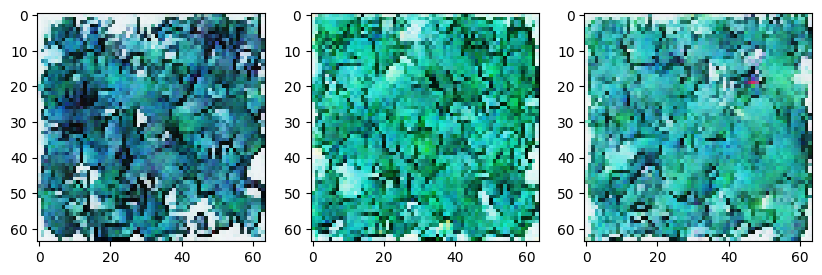

0.04724604:  20%|█▉        | 3999/20001 [06:37<23:02, 11.57it/s]  

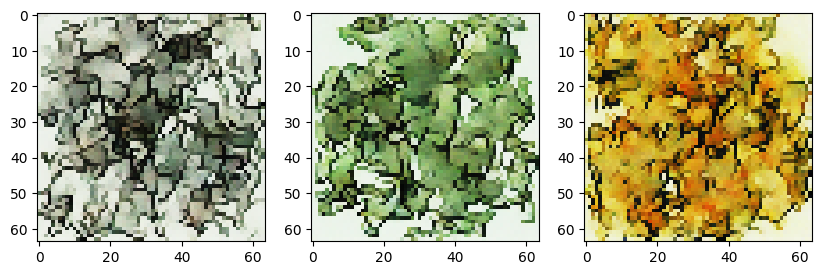

0.03600398:  22%|██▏       | 4499/20001 [07:27<22:20, 11.57it/s]  

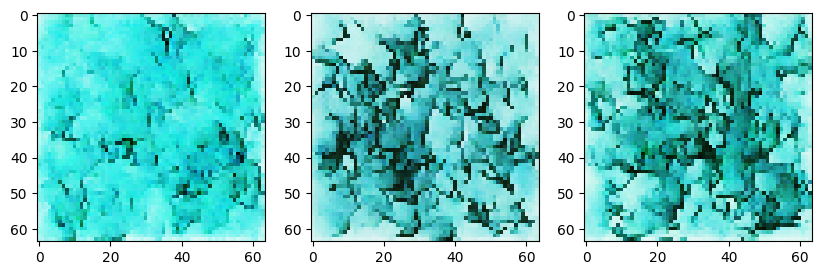

0.03814041:  25%|██▍       | 4999/20001 [08:17<21:37, 11.56it/s]  

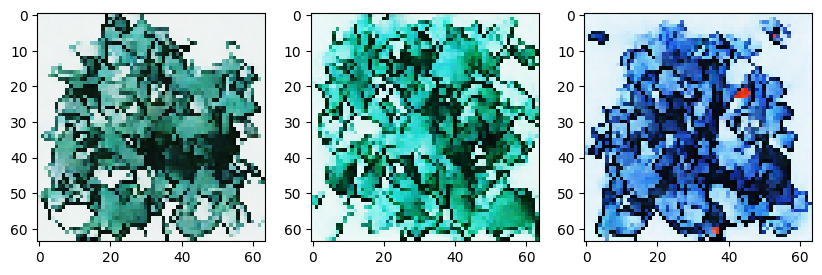

0.03062353:  27%|██▋       | 5499/20001 [09:06<20:52, 11.58it/s]  

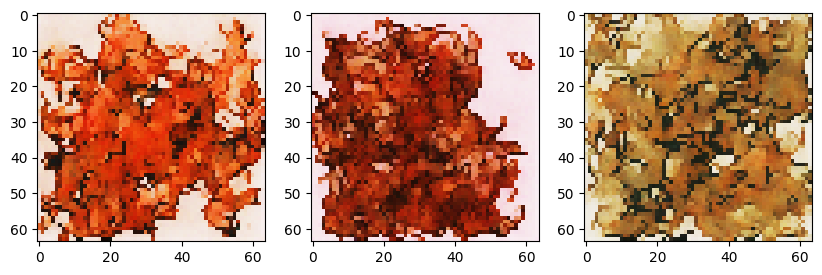

0.04852980:  30%|██▉       | 5999/20001 [09:56<20:11, 11.55it/s]  

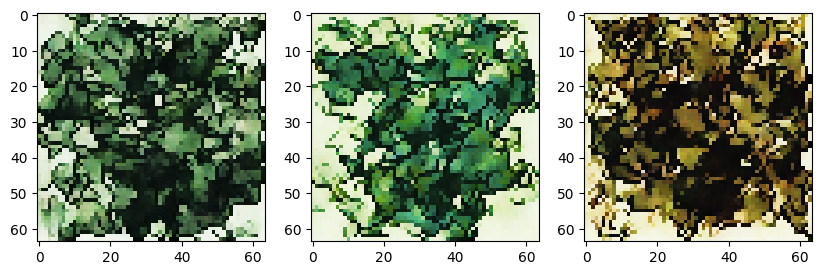

0.04034405:  32%|███▏      | 6499/20001 [10:46<19:26, 11.57it/s]  

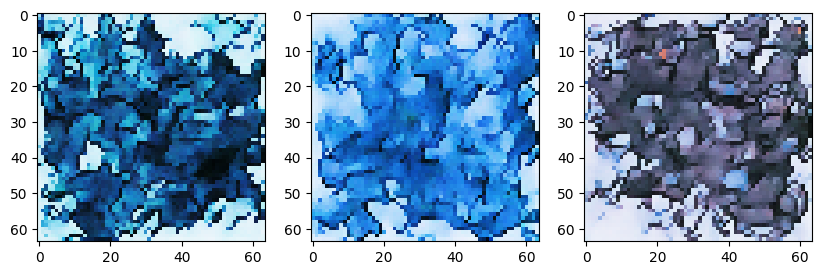

0.04221065:  35%|███▍      | 6999/20001 [11:35<18:44, 11.56it/s]  

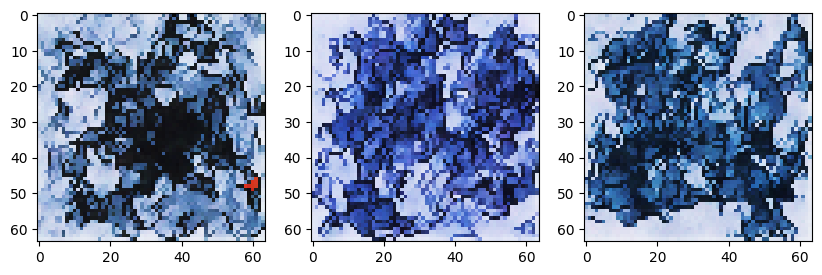

0.03474016:  37%|███▋      | 7499/20001 [12:25<18:01, 11.56it/s]  

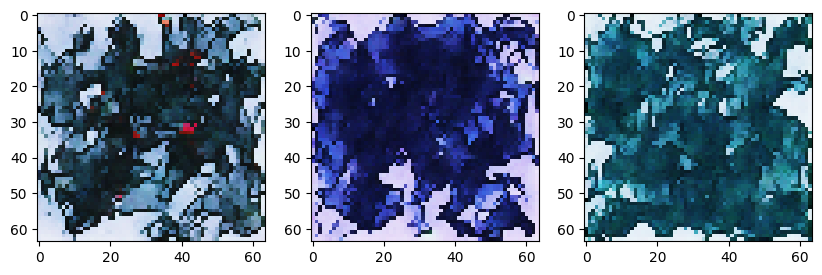

0.03169868:  40%|███▉      | 7999/20001 [13:15<17:17, 11.56it/s]  

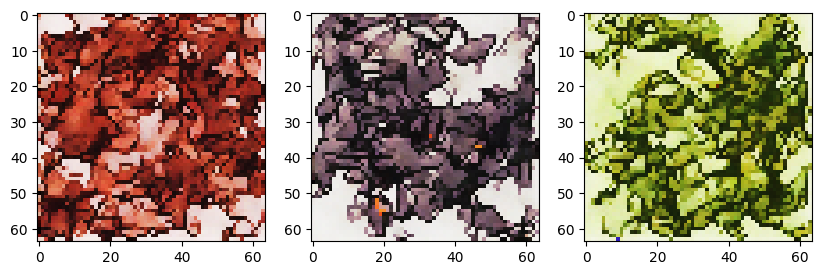

0.03489342:  42%|████▏     | 8499/20001 [14:04<16:34, 11.56it/s]  

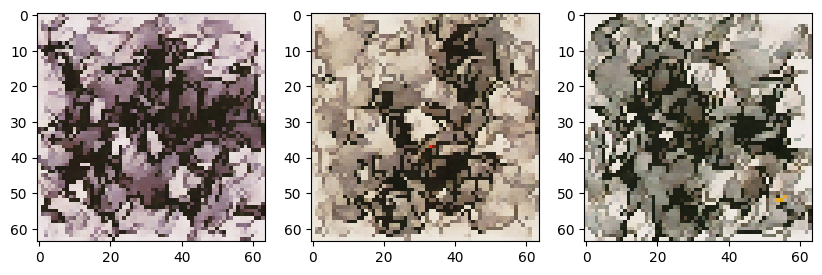

0.02242750:  45%|████▍     | 8999/20001 [14:54<15:51, 11.56it/s]  

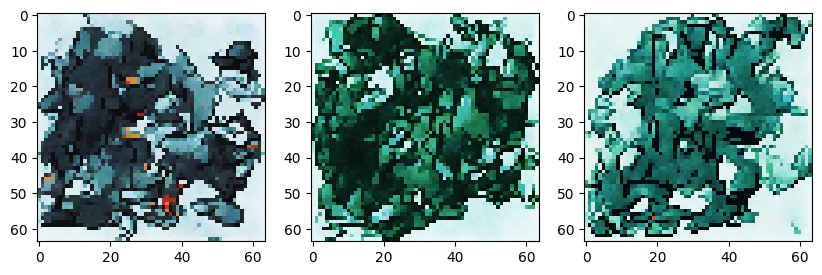

0.04079418:  47%|████▋     | 9499/20001 [15:44<15:08, 11.56it/s]  

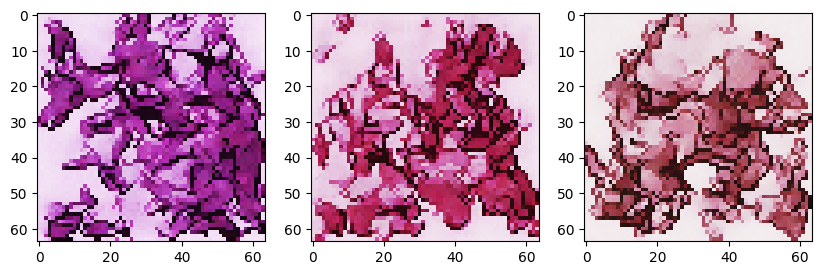

0.02949434:  50%|████▉     | 9999/20001 [16:33<14:25, 11.56it/s]  

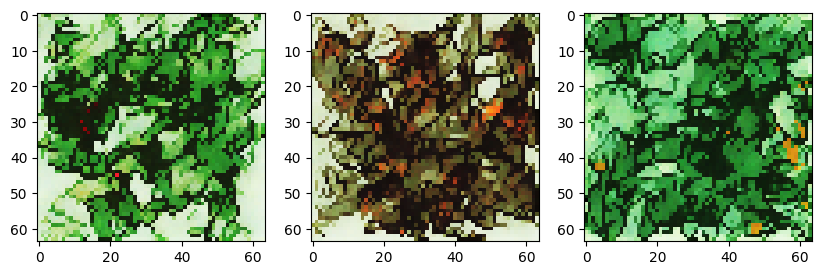

0.02574377:  52%|█████▏    | 10499/20001 [17:23<13:40, 11.58it/s]  

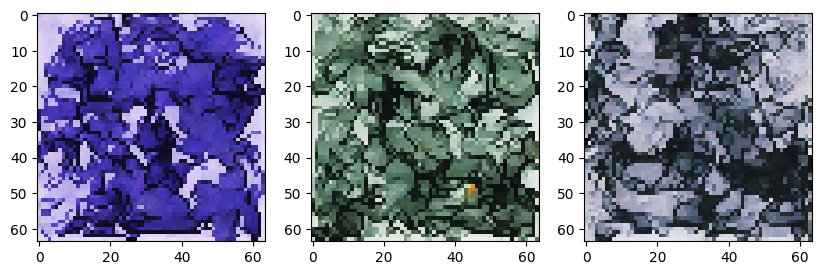

0.03628436:  55%|█████▍    | 10999/20001 [18:13<12:58, 11.56it/s]  

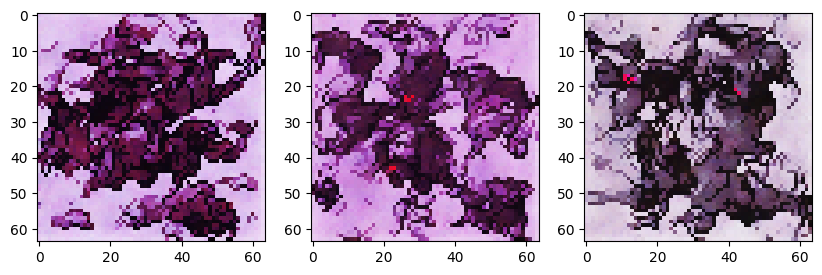

0.03448858:  57%|█████▋    | 11499/20001 [19:02<12:14, 11.57it/s]  

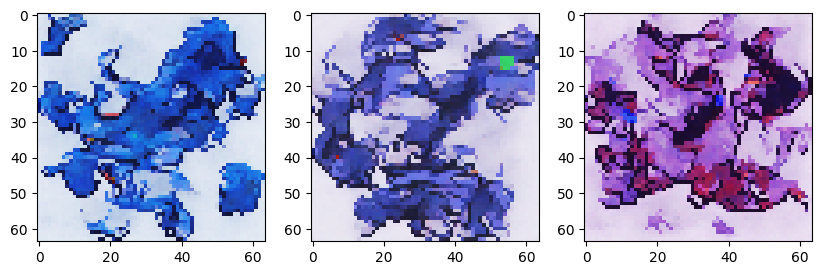

0.03459543:  60%|█████▉    | 11999/20001 [19:52<11:31, 11.58it/s]  

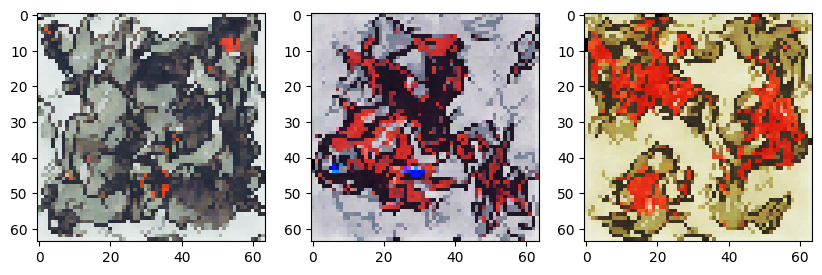

0.01943999:  62%|██████▏   | 12499/20001 [20:42<10:49, 11.55it/s]  

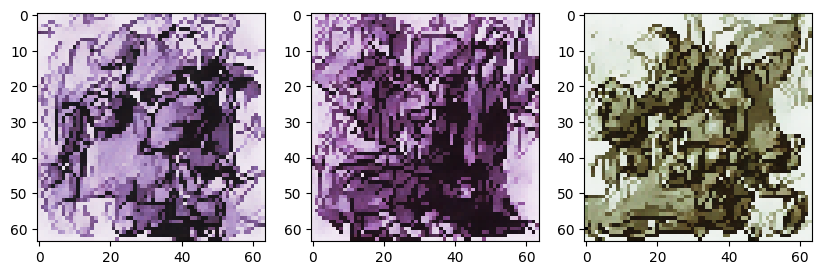

0.04456271:  65%|██████▍   | 12999/20001 [21:31<10:04, 11.58it/s]  

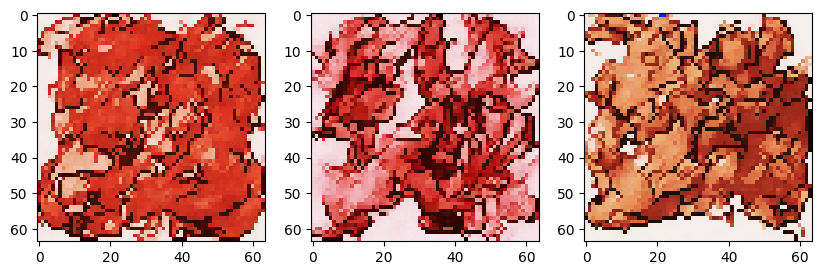

0.01728446:  67%|██████▋   | 13499/20001 [22:21<09:22, 11.56it/s]  

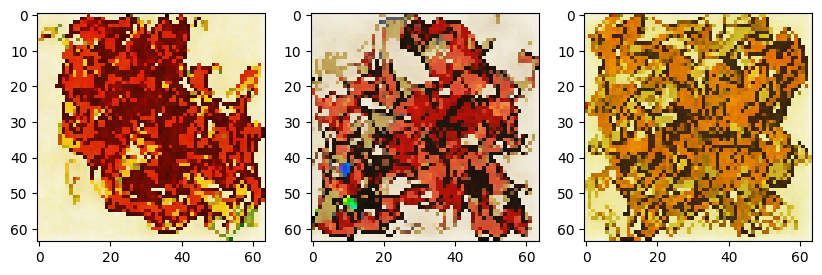

0.03148068:  70%|██████▉   | 13999/20001 [23:11<08:39, 11.56it/s]  

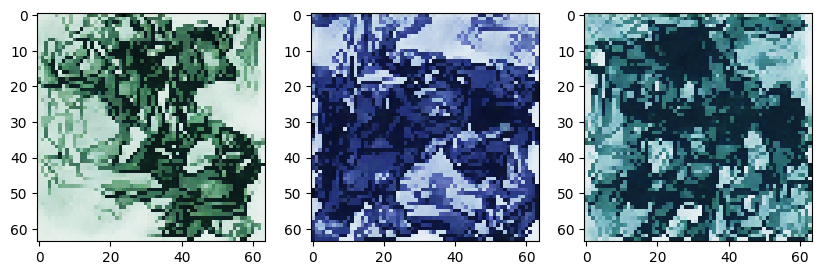

0.02796339:  72%|███████▏  | 14499/20001 [24:00<07:56, 11.56it/s]  

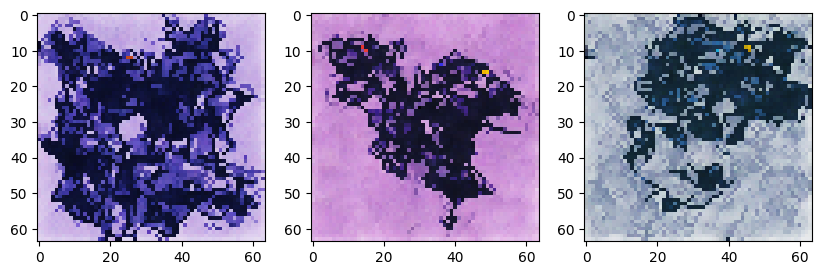

0.03211832:  75%|███████▍  | 14999/20001 [24:50<07:12, 11.57it/s]  

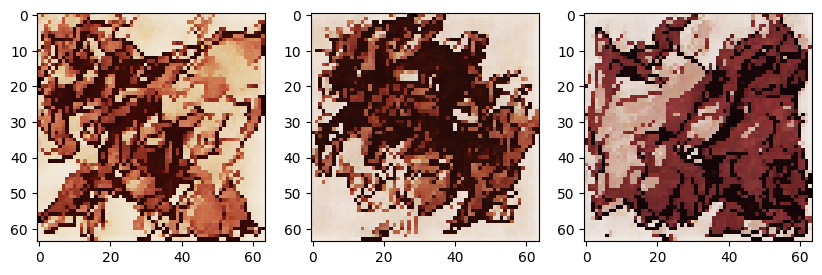

0.04274332:  77%|███████▋  | 15499/20001 [25:40<06:28, 11.58it/s]  

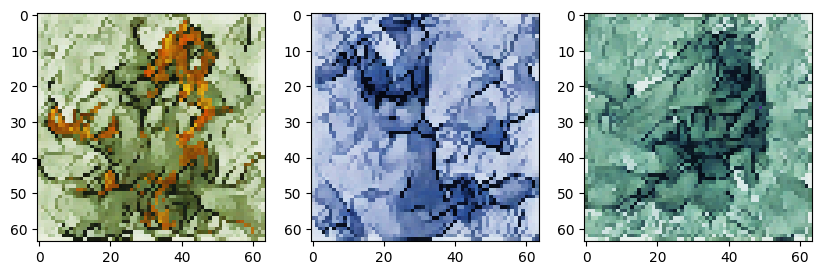

0.03205518:  80%|███████▉  | 15999/20001 [26:30<05:46, 11.56it/s]  

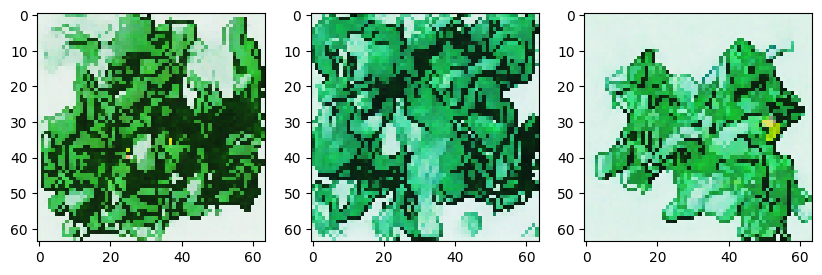

0.01938269:  82%|████████▏ | 16499/20001 [27:19<05:02, 11.58it/s]  

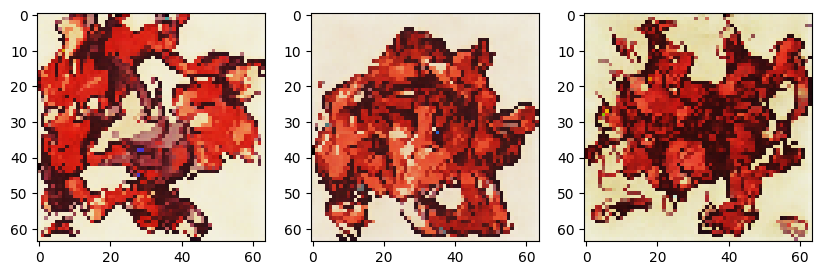

0.01813572:  85%|████████▍ | 16999/20001 [28:09<04:19, 11.57it/s]  

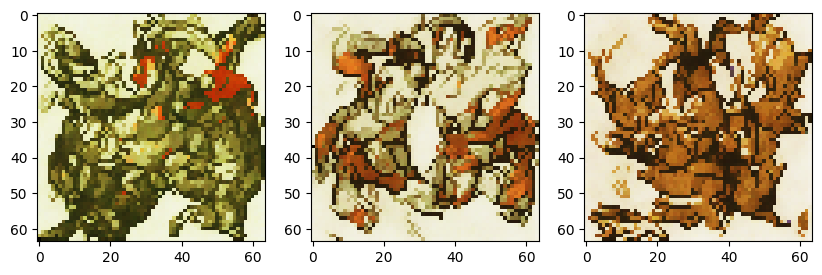

0.03114671:  87%|████████▋ | 17499/20001 [28:59<03:36, 11.57it/s]

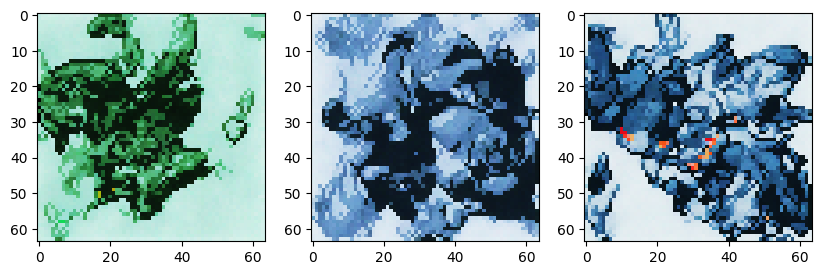

0.02709369:  90%|████████▉ | 17999/20001 [29:48<02:53, 11.56it/s]

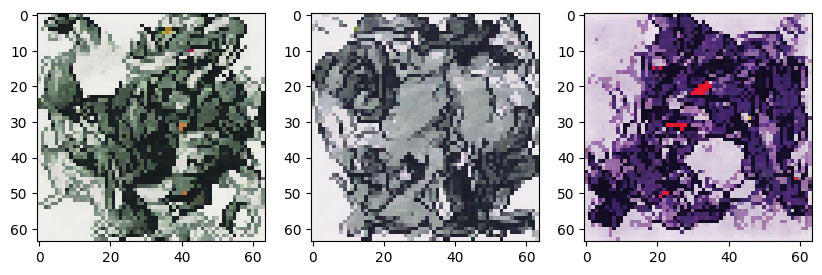

0.05076454:  92%|█████████▏| 18499/20001 [30:38<02:09, 11.58it/s]

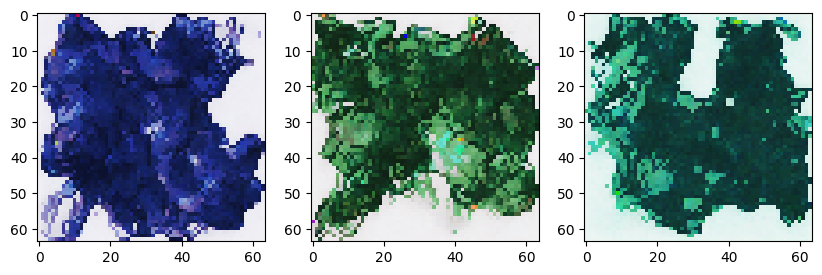

0.03741887:  95%|█████████▍| 18999/20001 [31:28<01:26, 11.59it/s]

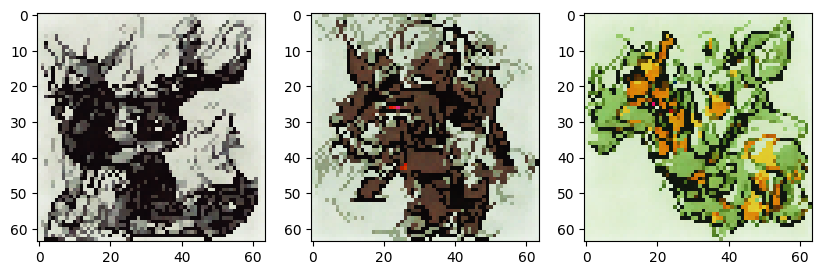

0.03811276:  97%|█████████▋| 19499/20001 [32:17<00:43, 11.57it/s]

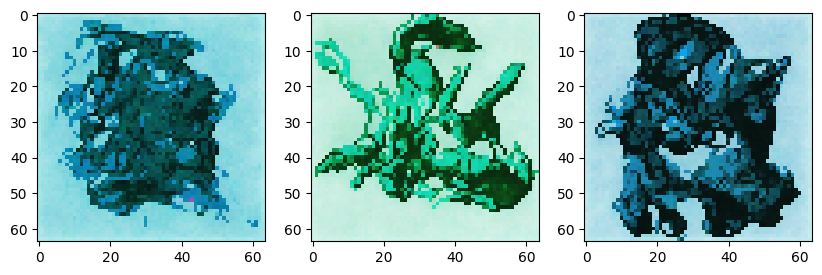

0.02304133: 100%|█████████▉| 19999/20001 [33:07<00:00, 11.56it/s]

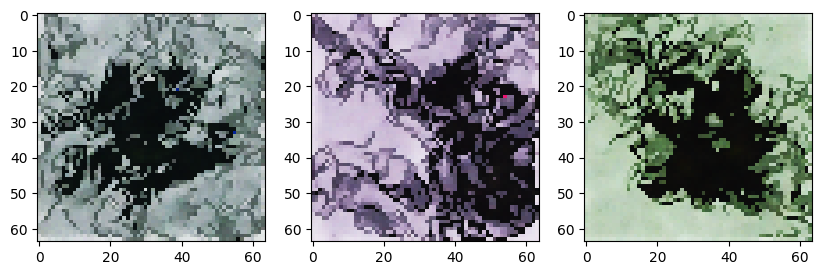

0.03093645: 100%|██████████| 20001/20001 [33:13<00:00, 10.03it/s]


In [7]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(20001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)
    
    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 500 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')